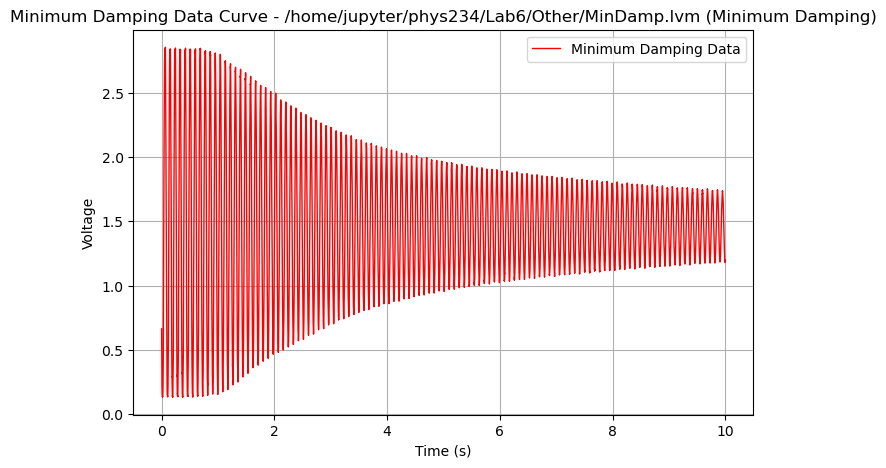

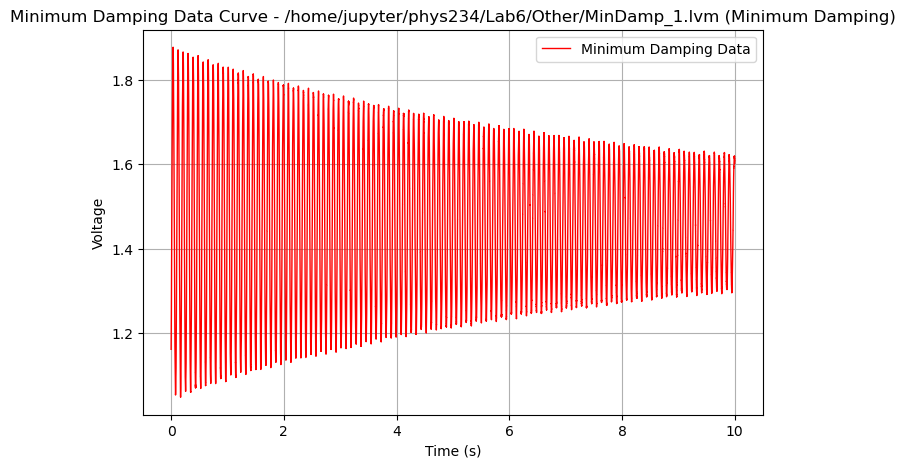

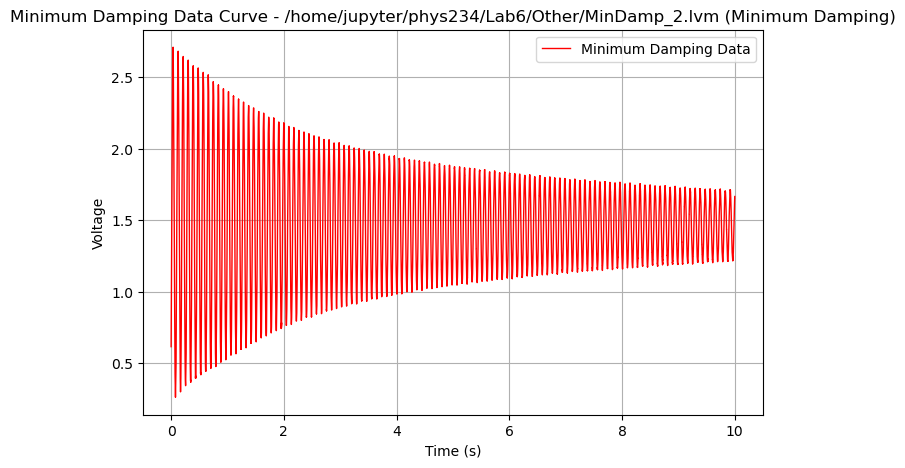

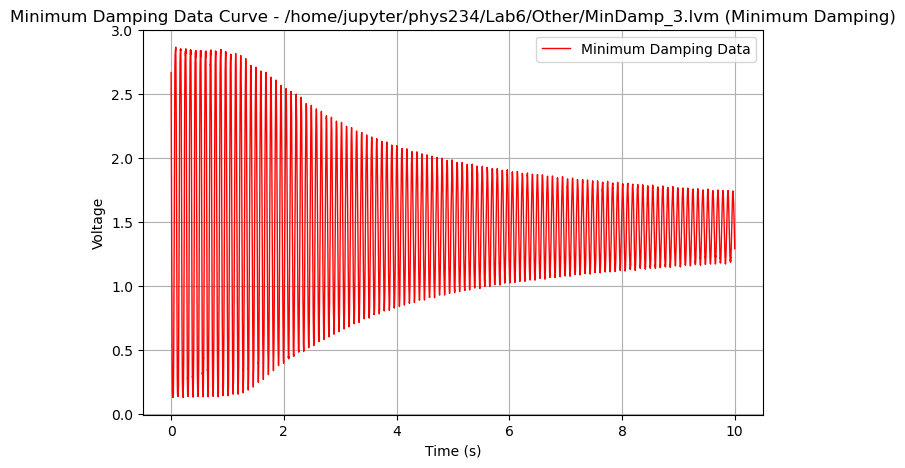

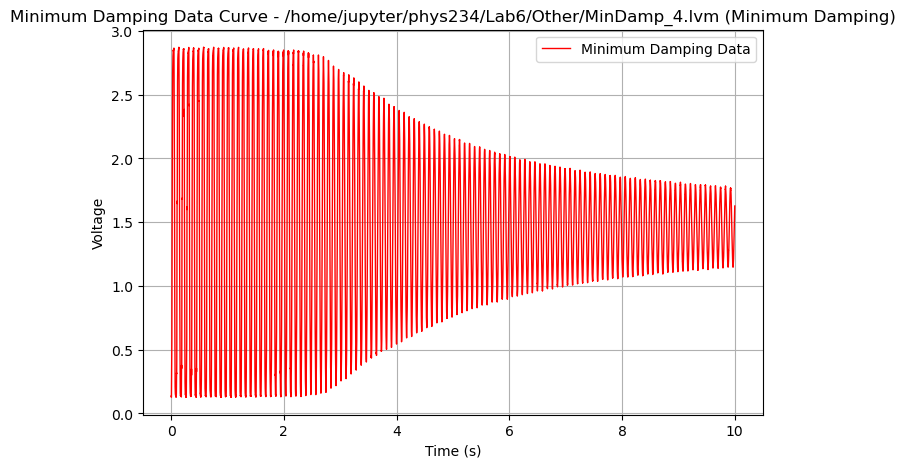

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define file paths for min damping level
min_damp_files = ["MinDamp.lvm", "MinDamp_1.lvm", "MinDamp_2.lvm", "MinDamp_3.lvm", "MinDamp_4.lvm"]
data_dir = "/home/jupyter/phys234/Lab6/Other/"  # Adjust as needed
min_damp_files = [os.path.join(data_dir, fname) for fname in min_damp_files]

# Function to plot original data curves
def plot_original_data(file_paths, damping_type):
    for file in file_paths:
        df = pd.read_csv(file, sep="\t", names=["Time", "Value1", "Value2"])
        plt.figure(figsize=(8, 5))
        plt.plot(df["Time"], df["Value1"], label="Minimum Damping Data", color="red", linewidth=1)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage")
        plt.legend()
        plt.title(f"Minimum Damping Data Curve - {file} ({damping_type} Damping)")
        plt.grid()
        plt.show()

# Plot original data for min damping level
plot_original_data(min_damp_files, "Minimum")

# SLICE ANALYSIS


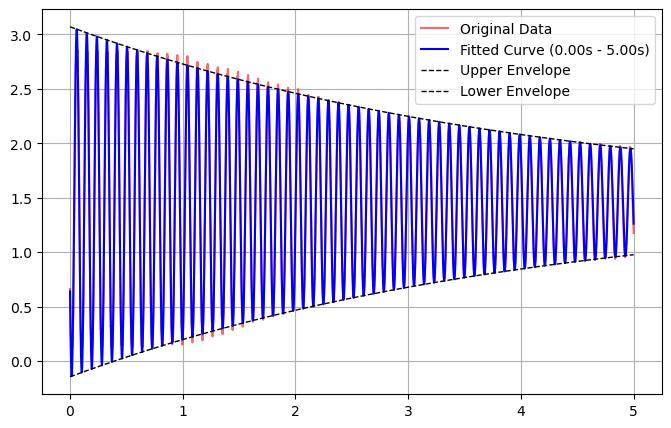

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp.lvm (0.00s - 5.00s, Minimum Damping):
  Amplitude (A): 1.6059
  Decay Rate (γ): 0.2392
  Frequency (f0): 11.1966 Hz
  Phase (φ): 2.1084
  Offset (C): 1.4633
  Quality Factor (Q): 147.0500



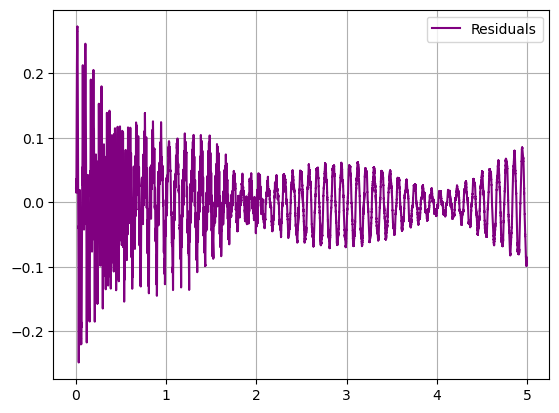

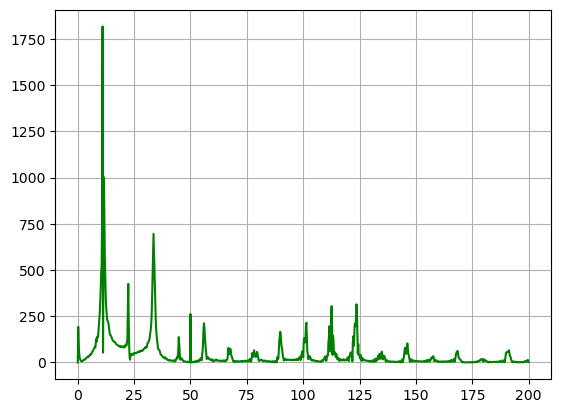

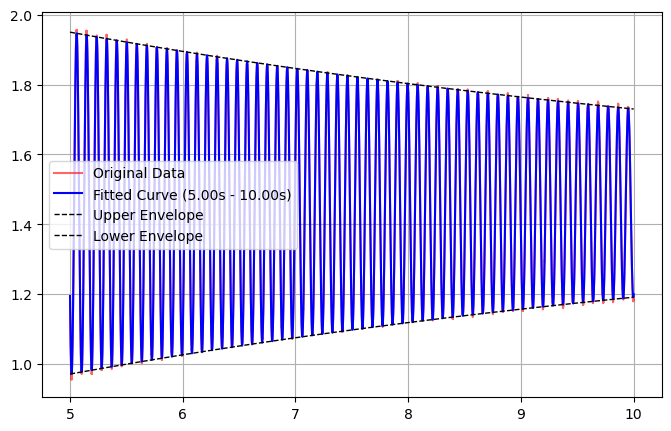

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp.lvm (5.00s - 10.00s, Minimum Damping):
  Amplitude (A): 0.4895
  Decay Rate (γ): 0.1194
  Frequency (f0): 11.2399 Hz
  Phase (φ): 2.1452
  Offset (C): 1.4606
  Quality Factor (Q): 295.7175



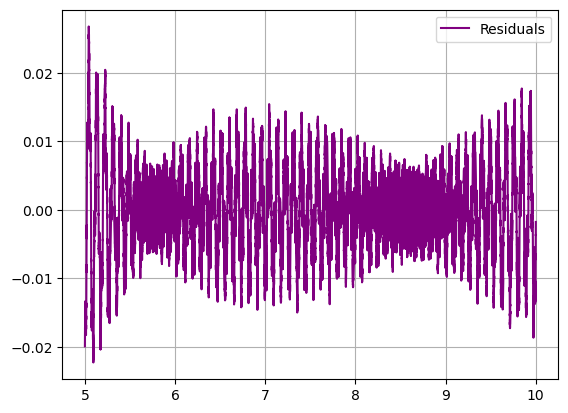

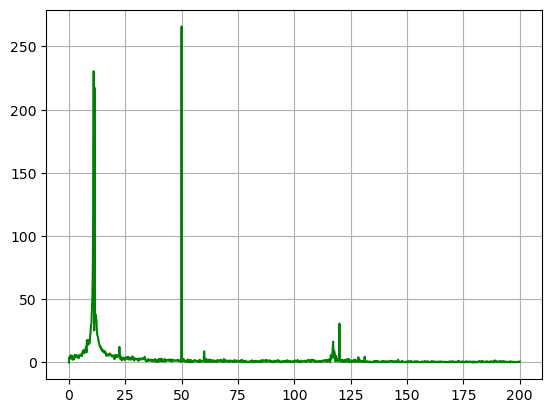

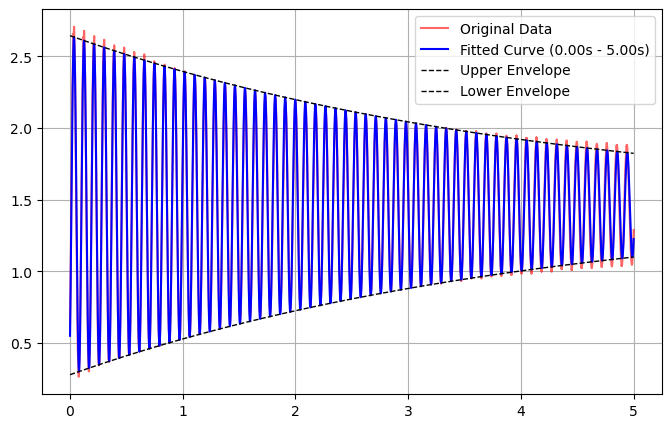

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp_2.lvm (0.00s - 5.00s, Minimum Damping):
  Amplitude (A): 1.1835
  Decay Rate (γ): 0.2370
  Frequency (f0): 11.2055 Hz
  Phase (φ): -2.4504
  Offset (C): 1.4615
  Quality Factor (Q): 148.5618



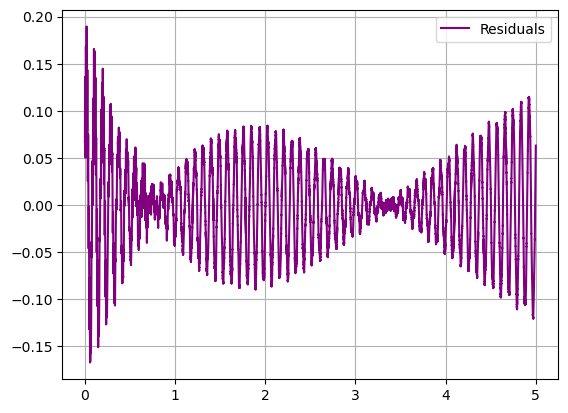

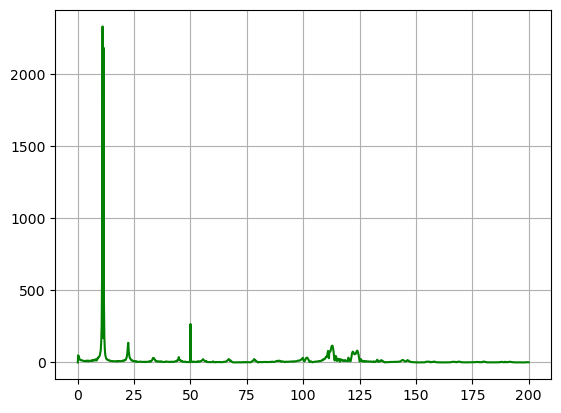

Error processing /home/jupyter/phys234/Lab6/Other/MinDamp_2.lvm (5.00s - 10.00s): `x0` is infeasible.


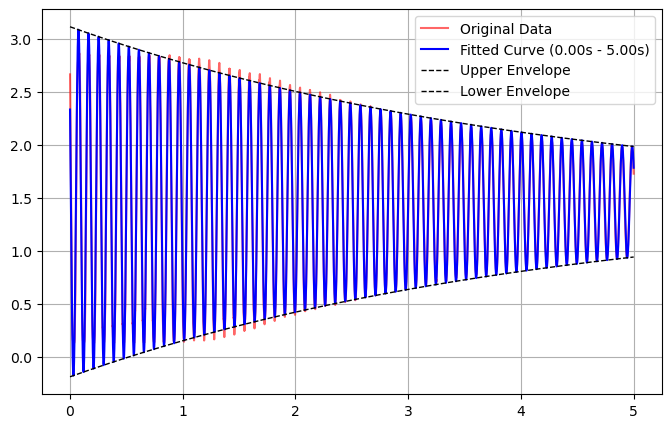

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp_3.lvm (0.00s - 5.00s, Minimum Damping):
  Amplitude (A): 1.6537
  Decay Rate (γ): 0.2306
  Frequency (f0): 11.1966 Hz
  Phase (φ): 1.0157
  Offset (C): 1.4642
  Quality Factor (Q): 152.5329



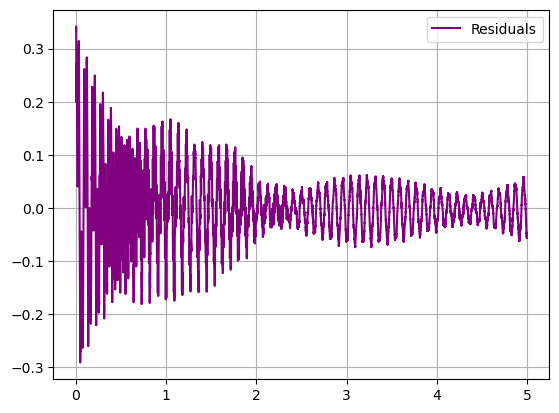

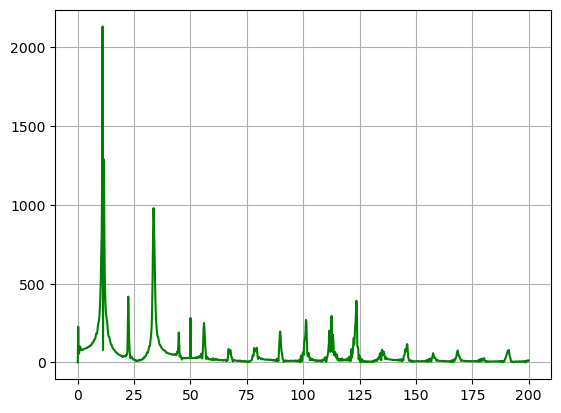

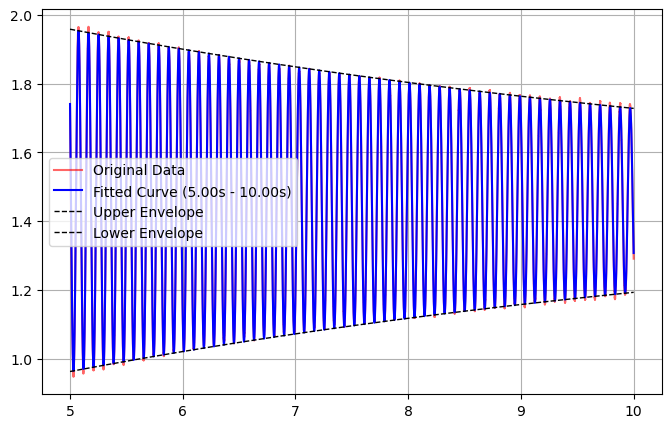

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp_3.lvm (5.00s - 10.00s, Minimum Damping):
  Amplitude (A): 0.4982
  Decay Rate (γ): 0.1242
  Frequency (f0): 11.2386 Hz
  Phase (φ): 0.9728
  Offset (C): 1.4606
  Quality Factor (Q): 284.1659



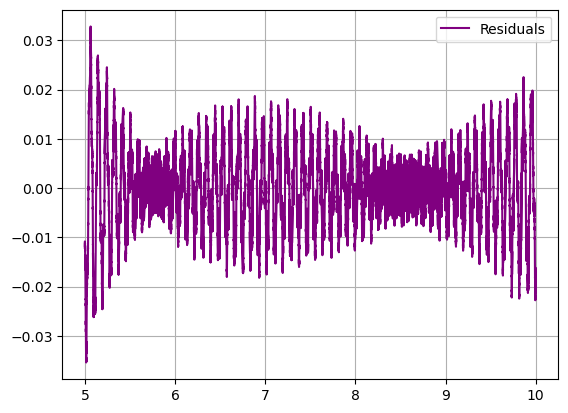

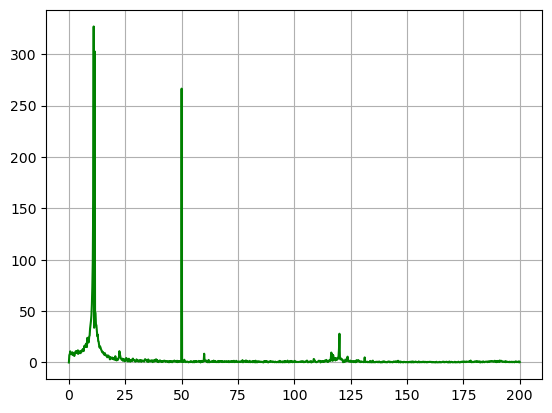

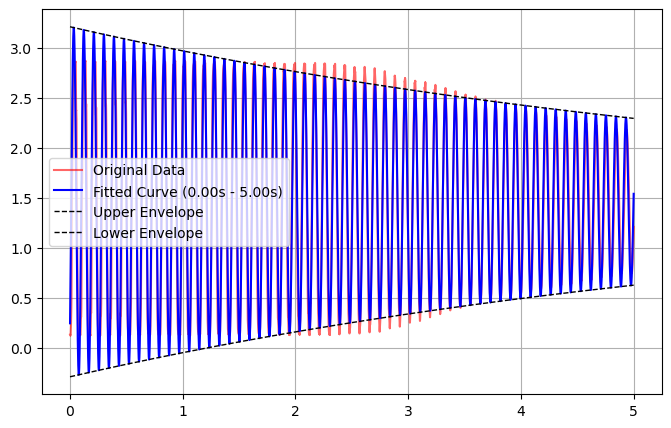

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp_4.lvm (0.00s - 5.00s, Minimum Damping):
  Amplitude (A): 1.7481
  Decay Rate (γ): 0.1482
  Frequency (f0): 11.2276 Hz
  Phase (φ): -2.3384
  Offset (C): 1.4633
  Quality Factor (Q): 237.9452



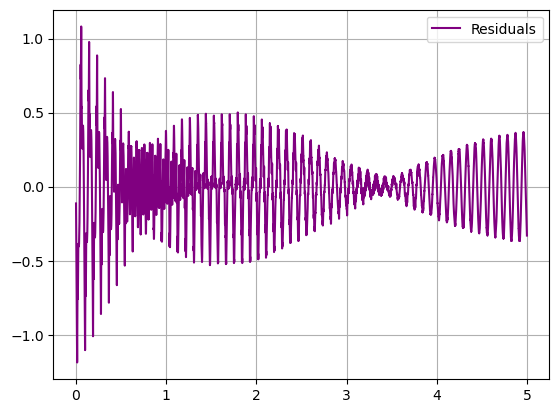

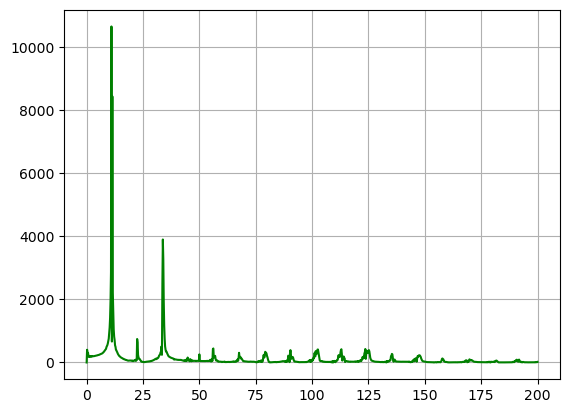

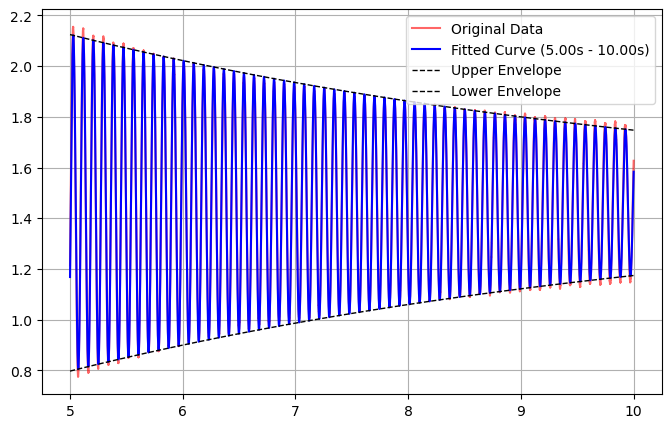

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp_4.lvm (5.00s - 10.00s, Minimum Damping):
  Amplitude (A): 0.6633
  Decay Rate (γ): 0.1679
  Frequency (f0): 11.2287 Hz
  Phase (φ): -2.0274
  Offset (C): 1.4608
  Quality Factor (Q): 210.0696



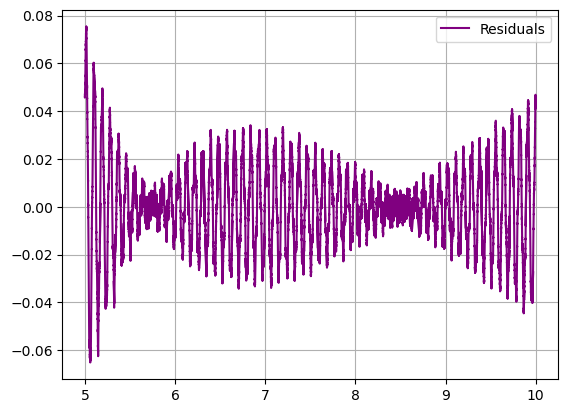

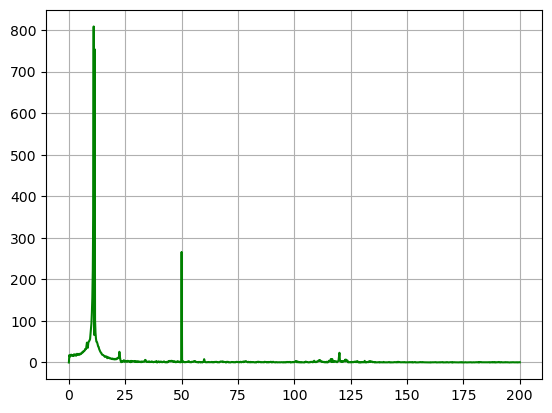

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import os

# File paths
data_dir = "/home/jupyter/phys234/Lab6/Other/"
min_damp_files = [os.path.join(data_dir, fname) for fname in [
  "MinDamp.lvm", "MinDamp_2.lvm", "MinDamp_3.lvm", "MinDamp_4.lvm"
]]

# Load data
def load_data(file):
    return pd.read_csv(file, sep="\t", names=["Time", "Value1", "Value2"])

# Model: exponentially decaying sine wave
def damped_sine_wave(t, A, gamma, omega, phi, C):
    return A * np.exp(-gamma * (t - t[0])) * np.cos(omega * (t - t[0]) + phi) + C

# Quality factor calculation
def calculate_Q(omega, gamma):
    if omega <= 0 or gamma <= 0:
        return np.nan
    return omega / (2 * gamma)

# Frequency estimation from FFT
def estimate_frequency(time, values):
    if len(values) < 10:
        return 2 * np.pi

    dt = np.mean(np.diff(time))
    freqs = fftfreq(len(values), dt)
    fft_values = np.abs(fft(values))

    peak_indices, _ = find_peaks(fft_values[:len(values) // 2])
    if len(peak_indices) == 0:
        return 2 * np.pi

    dominant_freq = freqs[peak_indices[np.argmax(fft_values[peak_indices])]]
    return abs(dominant_freq * 2 * np.pi)

# Decay rate estimation from peak envelope
def estimate_decay_rate(time, values):
    peak_indices, _ = find_peaks(values)
    if len(peak_indices) < 5:
        return 0.1

    peak_times = time[peak_indices]
    peak_values = np.abs(values[peak_indices])
    log_values = np.log(peak_values)

    slope, _ = np.polyfit(peak_times, log_values, 1)
    return abs(slope)

# Remove outliers using Median Absolute Deviation (MAD)
def remove_outliers(values, threshold=3):
    median = np.median(values)
    deviation = np.abs(values - median)
    mad = np.median(deviation)

    if mad == 0:
        return values

    z_scores = deviation / mad
    filtered = values[z_scores < threshold]

    if len(filtered) < 10:
        raise ValueError("All data removed as outliers")

    return filtered

# Divide data into 5-second slices
def get_slices(df, slice_duration=5.0):
    slices = []
    for t in np.arange(df["Time"].min(), df["Time"].max(), slice_duration):
        segment = df[(df["Time"] >= t) & (df["Time"] < t + slice_duration)]
        if len(segment) > 10:
            slices.append((segment, f"{t:.2f}s - {t+slice_duration:.2f}s"))
    return slices

# Analyze residuals (optional)
def analyze_residuals(time, residuals):
    if len(residuals) < 10:
        return

    dt = np.mean(np.diff(time))
    freqs = fftfreq(len(residuals), dt)
    fft_values = np.abs(fft(residuals))

    mask = (freqs >= 0) & (freqs <= 200)

    plt.figure()
    plt.plot(time, residuals, label="Residuals", color="purple")
    plt.grid(), plt.legend(), plt.show()

    plt.figure()
    plt.plot(freqs[mask], fft_values[mask], color="green")
    plt.grid(), plt.show()

# Fit each slice and plot with envelopes
def fit_and_analyze(file_paths, damping_type):
    for file in file_paths:
        df = load_data(file).sort_values("Time")
        slices = get_slices(df)

        for segment, label in slices:
            try:
                time = segment["Time"].values
                values = remove_outliers(segment["Value1"].values)

                omega = estimate_frequency(time, values)
                gamma = estimate_decay_rate(time, values)

                if omega < 2 * np.pi * 0.1 or omega > 2 * np.pi * 200:
                    raise ValueError(f"Unrealistic frequency estimate: {omega:.4f} rad/s")

                popt, _ = curve_fit(
                    damped_sine_wave, time, values,
                    p0=[np.ptp(values) / 2, gamma, omega, 0, np.mean(values)],
                    bounds=([0, 0.001, 2*np.pi*0.1, -np.pi, -np.inf], [np.inf, np.inf, 2*np.pi*200, np.pi, np.inf]),
                    maxfev=10000
                )

                A, gamma, omega, phi, C = popt
                f0 = omega / (2 * np.pi)
                Q = calculate_Q(omega, gamma)

                # Compute fitted curve and residuals
                fitted_values = damped_sine_wave(time, *popt)
                residuals = values - fitted_values

                # Compute upper and lower envelope curves
                envelope_upper = A * np.exp(-gamma * (time - time[0])) + C
                envelope_lower = -A * np.exp(-gamma * (time - time[0])) + C

                # Plot everything
                plt.figure(figsize=(8, 5))
                plt.plot(time, values, 'r', alpha=0.6, label="Original Data")
                plt.plot(time, fitted_values, 'b', label=f"Fitted Curve ({label})")
                plt.plot(time, envelope_upper, 'k--', label="Upper Envelope", linewidth=1)
                plt.plot(time, envelope_lower, 'k--', label="Lower Envelope", linewidth=1)
                plt.grid(), plt.legend(), plt.show()

                print(f"Fitted Parameters for {file} ({label}, {damping_type} Damping):")
                print(f"  Amplitude (A): {A:.4f}")
                print(f"  Decay Rate (γ): {gamma:.4f}")
                print(f"  Frequency (f0): {f0:.4f} Hz")
                print(f"  Phase (φ): {phi:.4f}")
                print(f"  Offset (C): {C:.4f}")
                print(f"  Quality Factor (Q): {Q:.4f}\n")

                analyze_residuals(time, residuals)
                plt.close('all')

            except Exception as e:
                print(f"Error processing {file} ({label}): {e}")

# Run analysis
fit_and_analyze(min_damp_files, "Minimum")


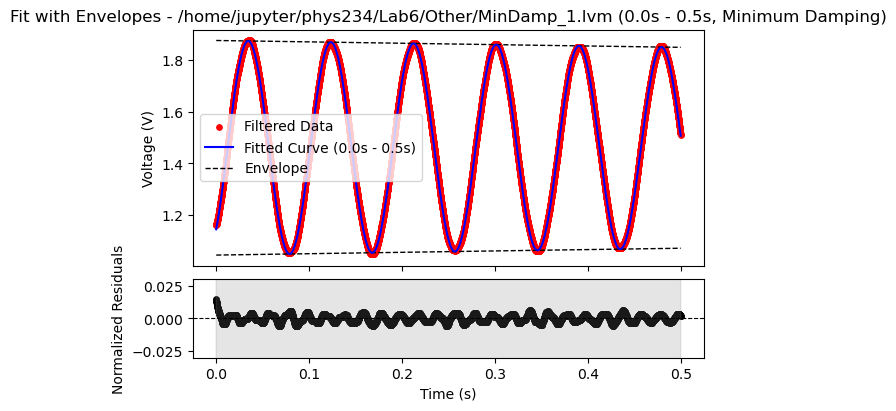

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp_1.lvm (0.0s - 0.5s, Minimum Damping):
  Amplitude (A): 0.4157
  Decay Rate (γ): 0.1318
  Frequency (f0): 11.2375 Hz
  Phase (φ): -2.4334
  Offset (C): 1.4608
  Quality Factor (Q): 267.9535




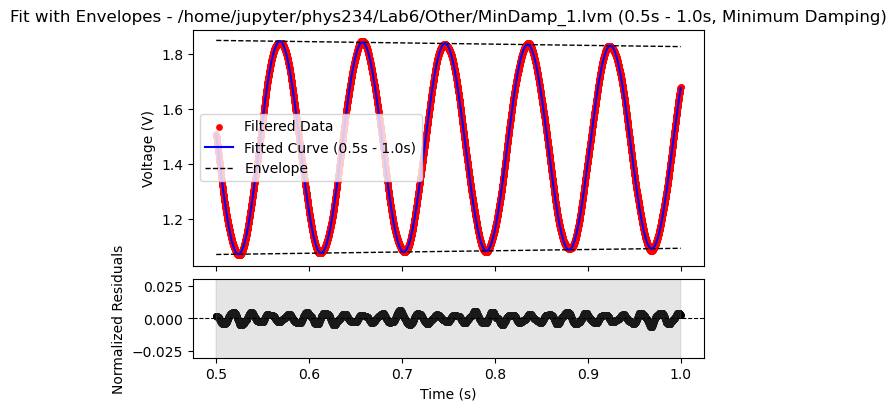

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/MinDamp_1.lvm (0.5s - 1.0s, Minimum Damping):
  Amplitude (A): 0.3891
  Decay Rate (γ): 0.1195
  Frequency (f0): 11.2395 Hz
  Phase (φ): 1.4541
  Offset (C): 1.4606
  Quality Factor (Q): 295.3637




In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, find_peaks
import os

min_damp_files = ["MinDamp.lvm", "MinDamp_1.lvm", "MinDamp_2.lvm", "MinDamp_3.lvm", "MinDamp_4.lvm"]
data_dir = "/home/jupyter/phys234/Lab6/Other/"  # Adjust as needed
min_damp_files = [os.path.join(data_dir, fname) for fname in min_damp_files]



def load_data(file):
    return pd.read_csv(file, sep="\t", names=["Time", "Value1", "Value2"])

def low_pass_filter(data, cutoff=50, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return filtfilt(b, a, data)

def damped_sine_wave(t, A, gamma, omega, phi, C):
    return A * np.exp(-gamma * (t - t[0])) * np.cos(omega * (t - t[0]) + phi) + C

def calculate_Q(omega, gamma):
    if omega <= 0 or gamma <= 0:
        return np.nan
    return omega / (2 * gamma)

def estimate_frequency(time, values):
    dt = np.mean(np.diff(time))
    freqs = fftfreq(len(values), dt)
    fft_values = np.abs(fft(values))
    peak_indices, _ = find_peaks(fft_values[:len(values)//2])
    if len(peak_indices) == 0:
        return 2 * np.pi
    dominant_freq = freqs[peak_indices[np.argmax(fft_values[peak_indices])]]
    return abs(dominant_freq * 2 * np.pi)

def get_slices(df, slice_duration=0.5, time_limit=1.0):
    start_time = df["Time"].min()
    end_time = min(df["Time"].max(), start_time + time_limit)
    slices = []
    for t in np.arange(start_time, end_time, slice_duration):
        segment = df[(df["Time"] >= t) & (df["Time"] < t + slice_duration)]
        if len(segment) > 10:
            slices.append((segment, f"{t:.1f}s - {t+slice_duration:.1f}s"))
    return slices

def plot_with_residuals(time, values, fitted_values, envelope_upper, envelope_lower, norm_residuals, file, label, damping_type):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), height_ratios=[3, 1], constrained_layout=True)
    sample_size = 2
    s = 15

    # Upper plot: Filtered data as points, fit as a line
    axs[0].scatter(time[::sample_size], values[::sample_size], color="red", s=s, label="Filtered Data", zorder=1)
    axs[0].plot(time, fitted_values, color="blue", label=f"Fitted Curve ({label})", zorder=2)
    axs[0].plot(time, envelope_upper, 'k--', label="Envelope", linewidth=1, zorder=1)
    axs[0].plot(time, envelope_lower, 'k--', linewidth=1, zorder=1)

    axs[0].set_ylabel("Voltage (V)")
    axs[0].legend()
    axs[0].set_title(f"Fit with Envelopes - {file} ({label}, {damping_type} Damping)")
    axs[0].tick_params(labelbottom=False)  # Hide x-axis labels on upper plot

    # Lower plot: Normalized residuals as points
    axs[1].scatter(time[::sample_size], norm_residuals[::sample_size], color='black', s=s)
    axs[1].axhline(0, color='k', linestyle='--', linewidth=0.8)
    axs[1].fill_between(time, -1, 1, color='gray', alpha=0.2)
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Normalized Residuals")
    axs[1].set_ylim(-0.03, 0.03)

    if not os.path.exists("saved_figures"):
        os.makedirs("saved_figures")

    fig_name = f"saved_figures/{file.replace('.lvm', '').replace('/', '_')}_{label.replace(' ', '_')}.pdf"
    plt.savefig(fig_name)
    plt.show()



def fit_and_analyze(file_paths, damping_type, slice_duration=0.5, time_limit=1.0):
    for file in file_paths:
        df = load_data(file).sort_values(by="Time")

        slices = get_slices(df, slice_duration, time_limit)

        for segment, label in slices:
            try:
                time = segment["Time"].values
                values = segment["Value1"].values
                values = low_pass_filter(values, cutoff=50, fs=1000)

                estimated_omega = estimate_frequency(time, values)

                A_guess = np.ptp(values) / 2
                gamma_guess = 0.05 if A_guess > 0.1 else 0.1
                phi_guess = 0
                C_guess = np.mean(values)

                weights = 1 / (np.abs(values) + 1e-3)

                popt, _ = curve_fit(
                    damped_sine_wave, time, values,
                    p0=[A_guess, gamma_guess, estimated_omega, phi_guess, C_guess],
                    bounds=([0, 0, 0, -np.pi, -np.inf], [np.inf, np.inf, np.inf, np.pi, np.inf]),
                    sigma=weights,
                    maxfev=50000
                )

                A, gamma, omega, phi, C = popt
                f0 = omega / (2 * np.pi)
                Q = calculate_Q(omega, gamma)

                fitted_values = damped_sine_wave(time, *popt)
                residuals = values - fitted_values

                envelope_upper = A * np.exp(-gamma * (time - time[0])) + C
                envelope_lower = -A * np.exp(-gamma * (time - time[0])) + C

                # Calculate normalized residuals
                uncertainties = 1 / weights
                norm_residuals = residuals / uncertainties

                plot_with_residuals(
                    time, values, fitted_values,
                    envelope_upper, envelope_lower,
                    norm_residuals, file, label, damping_type
                )

                print(f"Fitted Parameters for {file} ({label}, {damping_type} Damping):")
                print(f"  Amplitude (A): {A:.4f}")
                print(f"  Decay Rate (γ): {gamma:.4f}")
                print(f"  Frequency (f0): {f0:.4f} Hz")
                print(f"  Phase (φ): {phi:.4f}")
                print(f"  Offset (C): {C:.4f}")
                print(f"  Quality Factor (Q): {Q:.4f}")
                print("\n")

                
                # Ensure directory exists
                processed_data_dir = "/home/jupyter/phys234/Lab6/ProcessedData"
                if not os.path.exists(processed_data_dir):
                    os.makedirs(processed_data_dir)
                
                # Save data to file
                save_file_path = os.path.join(processed_data_dir, f"Transient_fit_MinDamping_data.txt")
                np.savetxt(
                    save_file_path,
                    np.column_stack((time, values, fitted_values, norm_residuals)),
                    header="Time(s)\tFilteredVoltage(V)\tFittedVoltage(V)\tNormalizedResiduals",
                    delimiter="\t",
                    fmt="%.6e"
                )


            except Exception as e:
                print(f"Error processing {file} ({label}): {e}")



#fit_and_analyze(max_damp_files, "Moderate", slice_duration=0.5, time_limit=1.0)
fit_and_analyze([min_damp_files[1]], "Minimum", slice_duration=0.5, time_limit=1.0)




